# Experiment Template


**In this notebook:**

* Template with comet ml optimizer 

**Todo:**


## Dependencies
Install, load, and initialize all required dependencies for this experiment.

### Install Dependencies

In [ ]:
#It should be possible to run the notebook independent of anything else. 
# If dependency cannot be installed via pip, either:
# - download & install it via %%bash
# - atleast mention those dependecies in this section

import sys
!{sys.executable} -m pip install -q -e ../../utils/
!{sys.executable} -m pip install multiprocessing



### Import Dependencies

# System libraries

In [1]:
from __future__ import absolute_import, division, print_function
import logging, os, sys

# Enable logging
logging.basicConfig(format='[%(levelname)s] %(message)s', level=logging.INFO, stream=sys.stdout)

# Re-import packages if they change
%load_ext memory_profiler
%load_ext autoreload
%autoreload 2

# Recursion Depth
sys.setrecursionlimit(1000000000)

# Intialize tqdm to always use the notebook progress bar
import tqdm

tqdm.tqdm = tqdm.tqdm_notebook

# Third-party libraries
import comet_ml

import numpy as np
import pandas as pd
import nilearn.plotting as nip
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import torch
import collections
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,6)
%config InlineBackend.figure_format='retina'  # adapt plots for retina displays
import git
import aneurysm_utils.evaluation as evaluation

# Project utils

import aneurysm_utils
from aneurysm_utils import evaluation, training,preprocessing


/group/cake/markus/.venv/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


KeyboardInterrupt: 

In [ ]:
if "workspace" in os.getcwd():
    ROOT = "/workspace" # local 
elif "/group/cake" in os.getcwd(): 
    ROOT = "/group/cake" # Jupyter Lab


### Initialize Environment

In [ ]:
env = aneurysm_utils.Environment(project="our-git-project", root_folder=ROOT)
env.cached_data["comet_key"] = "EGrR4luSis87yhHbs2rEaqAWs" 
env.print_info()

## Load Data
Download, explore, and prepare all required data for the experiment in this section.

In [ ]:
dataset_params = {
    "prediction": "mask",
    "mri_data_selection": "", 
    "balance_data": False,
    "seed": 1,
    "resample_voxel_dim": (1, 1, 1)
}

preprocessing_params = {
    'min_max_normalize': True,
    'mean_std_normalize': False,
    'smooth_img': False, # can contain a number: smoothing factor
    'intensity_segmentation': 0.15
}


### Load Meta Data

In [ ]:
from aneurysm_utils.data_collection import load_aneurysm_dataset

df = load_aneurysm_dataset(
    env,
    mri_data_selection=dataset_params["mri_data_selection"],
    random_state=dataset_params["seed"]
)
df.head()

### Load & Split MRI Data

In [ ]:
# Load MRI images and split into train, test, and validation
from aneurysm_utils.data_collection import split_mri_images
#case_list = [ "A123", "A121", "A124"] # "A003","A005","A006","A008", "A010", "A012","A009", "A120",
#df = df.loc[df["Case"].isin(case_list)]

train_data, test_data, val_data, _ = split_mri_images(
    env, 
    df, 
    prediction=dataset_params["prediction"], 
    encode_labels=False,
    random_state=dataset_params["seed"],
    balance_data=dataset_params["balance_data"],
    resample_voxel_dim=dataset_params["resample_voxel_dim"]
)

mri_imgs_train, labels_train = train_data
mri_imgs_test, labels_test = test_data
mri_imgs_val, labels_val = val_data

In [ ]:
from aneurysm_utils import preprocessing

most_commen_shape = preprocessing.check_mri_shapes(mri_imgs_train)

## Transform & Preprocess Data

In [ ]:
size = most_commen_shape  #(139, 139, 120)
train_index = [i for i, e in enumerate(mri_imgs_train) if e.shape != size]
mri_imgs_train = [i for j, i in enumerate(mri_imgs_train) if j not in train_index]
labels_train = [i for j, i in enumerate(labels_train) if j not in train_index]

test_index = [i for i, e in enumerate(mri_imgs_test) if e.shape != size]
mri_imgs_test = [i for j, i in enumerate(mri_imgs_test) if j not in test_index]
labels_test = [i for j, i in enumerate(labels_test) if j not in test_index]

val_index = [i for i, e in enumerate(mri_imgs_val) if e.shape != size]
mri_imgs_val = [i for j, i in enumerate(mri_imgs_val) if j not in val_index]
labels_val = [i for j, i in enumerate(labels_val) if j not in val_index]

mri_imgs_train[0].shape
preprocessing.check_mri_shapes(mri_imgs_train)
print(np.unique(labels_val[0], return_counts=True))

In [ ]:
def patch_creater(image, patch_size, test = None):
    """
    Creates overlapping patches from  preprocessed image, the number of patches is fixed to certain value
    and the size can be changed as well
    ----------
    image: numpy.array
        image which will be sliced into patches
    patch_size: tuple of int
        size of the patch, equal in each direction
   
    Returns
    -------
    numpy.array  (n_patches,channels,patch_size,patch_size,patch_size)
        list containing the patches

    """
    
    


    dim = np.array(image.shape)# size of the image
    n_patches = np.ceil(dim/patch_size).astype(int) # calculates the number of patches for each dim, to cover all voxel at least once
    rest  = n_patches * patch_size%dim ## calculates the remaining voxel which are going to overlap 

    patches = []
    for i in range(n_patches[0]):
        
        if i == n_patches[0]-1: ## only the last cube is an overlapped cube
            start_x = i*patch_size-rest[0]## indices were to start and stop the slicing true the image array
            stop_x= (i+1)* patch_size-rest[0]
              
        else:    
            start_x = i*patch_size
            stop_x = (i+1)* patch_size

        
              
        for j in range(n_patches[1]):
            if j == n_patches[1]-1: ## only the last cube is an overlapped cube
                start_y = j*patch_size-rest[1]
                stop_y= (j+1)* patch_size-rest[1]
              
            else:    
                start_y = j*patch_size
                stop_y = (j+1)* patch_size
            
            for k in range(n_patches[2]):
                if k == n_patches[2]-1: 
                    start_z = k*patch_size-rest[2]
                    stop_z = (k+1)* patch_size-rest[2]
              
                else:    
                    start_z = k*patch_size
                    stop_z = (k+1)* patch_size

                if test:
                    
                    patches.append(torch.from_numpy(image[start_x:stop_x,start_y:stop_y,start_z:stop_z]))
                else:
                    patches.append(image[start_x:stop_x,start_y:stop_y,start_z:stop_z])
        
    #return np.array([*patches])
    return patches

In [ ]:
def patch_list(data,patch_size,test = None):
    """
    data: numpy.array
        containing dataset of dimensions (size_of_set,height,width,depth),e.g. (75,139,139,120)
    patch_size: int
    
    Return
    
    list_patch: list
        each element is one image of type numpy.array/torch.tensor with dimensions(n_classes,most_common_shape),
    """
    list_patch = []

    
    for n in range(len(data)):
        patch = patch_creater(data[n],patch_size,test)
        list_patch = list_patch+patch
    

    return list_patch

In [ ]:
from aneurysm_utils import preprocessing
patch_size = 64
size_of_train = len(mri_imgs_train)
size_of_test = len(mri_imgs_test)
size_of_val = len(mri_imgs_val)

# preprocess all lists as one to have a working mean_std_normalization
mri_imgs = mri_imgs_train + mri_imgs_test + mri_imgs_val
mri_imgs = preprocessing.preprocess(env, mri_imgs, preprocessing_params)
###creating patches
mri_imgs_train = np.asarray(mri_imgs[:size_of_train])
mri_imgs_train = patch_list(mri_imgs_train,patch_size)
mri_imgs_test = np.asarray(mri_imgs[size_of_train : size_of_train + size_of_test])
mri_imgs_test = patch_list(mri_imgs_test,patch_size)
mri_imgs_val = np.asarray(mri_imgs[size_of_train + size_of_test :])
mri_imgs_val = patch_list(mri_imgs_val,patch_size)

# preprocess mask
x, y, h = labels_train[0].shape
labels_train = patch_list(labels_train,patch_size)
labels_test = patch_list(labels_test,patch_size)
labels_val = patch_list(labels_val,patch_size)

In [ ]:
del mri_imgs_train
del mri_imgs_val

In [ ]:
mri_imgs_train[0].shape,len(mri_imgs_train),type(mri_imgs_test),len(mri_imgs_test),type(mri_imgs_val),len(mri_imgs_val)

### Optional: View image

In [ ]:
idx = 0
nip.view_img(
    nib.Nifti1Image(mri_imgs_train[0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)

In [ ]:
evaluation.plot_slices(mri_train[0])

## Train Model
Implementation, configuration, and evaluation of the experiment.

### Train Deep Model 3D data

In [ ]:
from comet_ml import Optimizer

artifacts = {
    "train_data": (mri_imgs_train, labels_train),
    "val_data": (mri_imgs_val, labels_val),
    "test_data": (mri_imgs_test, labels_test)
}

# Define parameter configuration for experiment run
params = {
    "batch_size": 3,
    "epochs": 100,
    "es_patience": None, # None = deactivate early stopping
    "model_name": 'Attention_Unet',
    "optimizer_momentum": 0.9,
    "optimizer":'Adam',
    "criterion": "CrossEntropyLoss",
    "sampler": None,   #'ImbalancedDatasetSampler2',
    "shuffle_train_set": True,
    "save_models":True,
    "debug": True,
    "criterion_weights": 100,
    "learning_rate": 1e-5,
    "weight_decay": 1e-3,
}

params.update(dataset_params)
params.update(preprocessing_params)

config = {
    # We pick the Bayes algorithm:
    "algorithm": "bayes",
    # Declare your hyperparameters in the Vizier-inspired format:
    "parameters": {
       "criterion_weights": {"type": "integer", "scalingType": "loguniform", "min": 1, "max": 10000},
       "dropout": {"type": "float", "scalingType": "loguniform", "min": 0.1, "max": 0.5},
       "learning_rate": {"type": "float", "scalingType": "loguniform", "min": 1e-10, "max": 1e-2},
        "scheduler": {"type": "categorical", "values": ["ReduceLROnPlateau", ""]},
         "weight_decay": {"type": "float", "scalingType": "loguniform", "min": 1e-10, "max": 9e-1},
    },
    # Declare what we will be optimizing, and how:
    "spec": {"metric": "train_bal_acc", "objective": "maximize"},  #test balance accuracy
}


opt = Optimizer(config, api_key=env.cached_data["comet_key"])

In [ ]:
# Finally, get experiments, and train your models:
for comet_exp in opt.get_experiments(project_name=env.project + "-" + params["prediction"]):
    print(comet_exp)
    param_copy = params.copy()
    comet_exp.params
    
    param_copy["dropout"] = comet_exp.get_parameter("dropout")
    param_copy["criterion_weights"] = comet_exp.get_parameter("criterion_weights")
    param_copy["learning_rate"] = comet_exp.get_parameter("learning_rate")
    param_copy["scheduler"] = comet_exp.get_parameter("scheduler")
    param_copy["weigtht_decay"] = comet_exp.get_parameter("weight_decay")

    exp = env.create_experiment(
        params["prediction"] + "-pytorch-" + params["model_name"], comet_exp
    ) #params["selected_label"] + "-hyperopt-" + params["model_name"]
    exp.run(training.train_pytorch_model, param_copy, artifacts)

In [ ]:
!free -m

In [ ]:
#test tomorrow old voxel size

## Evaluate Model

Do evaluation, e.g. visualizations  

In [ ]:
from aneurysm_utils.utils.pytorch_utils import predict
from aneurysm_utils.models.attention_unet import unet_grid_attention_3D

In [ ]:
model = exp.artifacts["model"]

In [ ]:
model = unet_grid_attention_3D(feature_scale=4, n_classes=2, is_deconv=True, in_channels=1,
                 nonlocal_mode='concatenation', attention_dsample=(2,2,2), is_batchnorm=True)
PATH = "/group/cake/our-git-project/experiments/2021-07-05-23-19-28_mask-pytorch-attention-unet/Attention_Unet_Attention_Unet_45000.pt"
device = torch.device('cpu')


model.load_state_dict(torch.load(PATH, map_location=device))

In [ ]:
from aneurysm_utils.utils import pytorch_utils
from torch.utils.data.dataloader import DataLoader
test_dataset = pytorch_utils.PytorchDataset(
                mri_imgs_test,
                labels_test,
                dtype=np.float64,
                
            )



In [ ]:
test_loader = DataLoader(
            test_dataset,
            batch_size=1,  # TODO: use fixed batch size of 5
            shuffle=False,
            num_workers=0,
            pin_memory=True,
        )
predictions = predict(model, test_loader, apply_softmax=False )

In [ ]:
converter = map(lambda x: x[0], predictions)
preds = list(converter)


In [ ]:

np.save("/group/cake/our-git-project/develop/markus/predictions.npy",preds)

In [3]:
p = np.load("/group/cake/our-git-project/develop/markus/predictions.npy")

In [6]:
converter = map(lambda x: x[0], p)
preds = list(converter)

In [41]:
def unify_alternativ(image, patch_size,most_common_shape):
    """
    image: numpy.array
          shape is (number_of_patches,h,w,d) , number_of_patches,heigth,width,depth
    patch_size: int
            e.g. 64
    most_common_shape: tuple
                for example(139,139,120)

    Return

    image: np.array

          unified and unpatch image, shape (most_common_shape)


    """
    number_of_patches,heigth,width,depth = image.shape

    dim = np.array(most_common_shape)# size of the image
    n_patches = np.ceil(dim/patch_size).astype(int) # calculates the number of patches for each dim, to cover all voxel at least once in form e.g[3,3,2]
    rest  = n_patches * patch_size%dim ## calculates number of entries for each dimension which overlapp, means for example n_patches = 18 and 64 we have rest = 53
    
    h,w,d = most_common_shape

    ## initializing empty array for the unified image
    unified_image =  np.empty([h,w,d])

    counter = 0 ## counter for patches
    

    
    for i in range(n_patches[0]):

        if i == n_patches[0]-1: ## only the last cube is an overlapped cube
          start_x = i*patch_size-rest[0]
          stop_x= (i+1)* patch_size-rest[0]

        else:    
          start_x = i*patch_size
          stop_x = (i+1)* patch_size



        for j in range(n_patches[1]):
            if j == n_patches[1]-1: ## only the last cube is an overlapped cube
                start_y = j*patch_size-rest[1]
                stop_y= (j+1)* patch_size-rest[1]

            else:    
                start_y = j*patch_size
                stop_y = (j+1)* patch_size

            for k in range(n_patches[2]):
                if k == n_patches[2]-1: 
                    start_z = k*patch_size-rest[2]
                    stop_z = (k+1)* patch_size-rest[2]

                else:    
                    start_z = k*patch_size
                    stop_z = (k+1)* patch_size


              ##maximum between channel one or two, probably not necessary
              #max_class = np.maximum(image[n,0,:,:,:],image[n,1,:,:,:])

              ###includes overlapping case
              #unified_image[start_x:stop_x,start_y:stop_y,start_z:stop_z] = np.maximum(unified_image[start_x:stop_x,start_y:stop_y,start_z:stop_z],max_class)
                unified_image[start_x:stop_x,start_y:stop_y,start_z:stop_z] = np.maximum(unified_image[start_x:stop_x,start_y:stop_y,start_z:stop_z],image[counter,:,:,:])
                
                counter+=1## next patch
                
                if (counter==18):
                    break;
    
    return unified_image


In [42]:
def patch_unifier_alternativ(list_patches,size_test_set,most_common_shape,patch_size):
  """
  list_patches: list
                containing predictions from the evaluations, length should be number_of_patches x length_test_set
                each element should have the form (h,w,d)
  size_test_set: int

  most_common_shape: tuple
                most_common shape from the original input images before patchifying
  
  patch_size: int



  Return:

  unified_images: list
                contains the unpatched images 
                each element has the shape:(most_common_shape) 

  """
  
  dim = np.array(most_common_shape)
  n_patches = np.ceil(dim/patch_size).astype(int)# output is number of patches per dimension

  number_of_patches = np.prod(n_patches)# number of patches overall

  h,w,d = most_common_shape
  
  unified_images = []
  assert (len(list_patches)/(number_of_patches))== size_test_set
  

  ##output list: each element has the form (number_of_patches,n_classes,h,w,d)
  images = np.split(np.array(list_patches),size_test_set)  

  for n in range(size_test_set):
        
        unified_images.append(unify_alternativ(images[n],patch_size,most_common_shape))
  assert len(unified_images) == size_test_set
  return unified_images

In [44]:
uni = patch_unifier_alternativ(preds,9,(139,139,120),64)

In [22]:
len(uni),type(uni),uni[0].shape

(9, list, (139, 139, 120))

In [ ]:
len(labels_test),type(labels_test), labels_test[0].shape

In [ ]:

idx = 0
nip.view_img(
    nib.Nifti1Image(uni[0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)

In [ ]:
idx = 0
nip.view_img(
    nib.Nifti1Image(uni_labels[0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)

In [ ]:
idx = 0
nip.view_img(
    nib.Nifti1Image(labels_test[0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False)

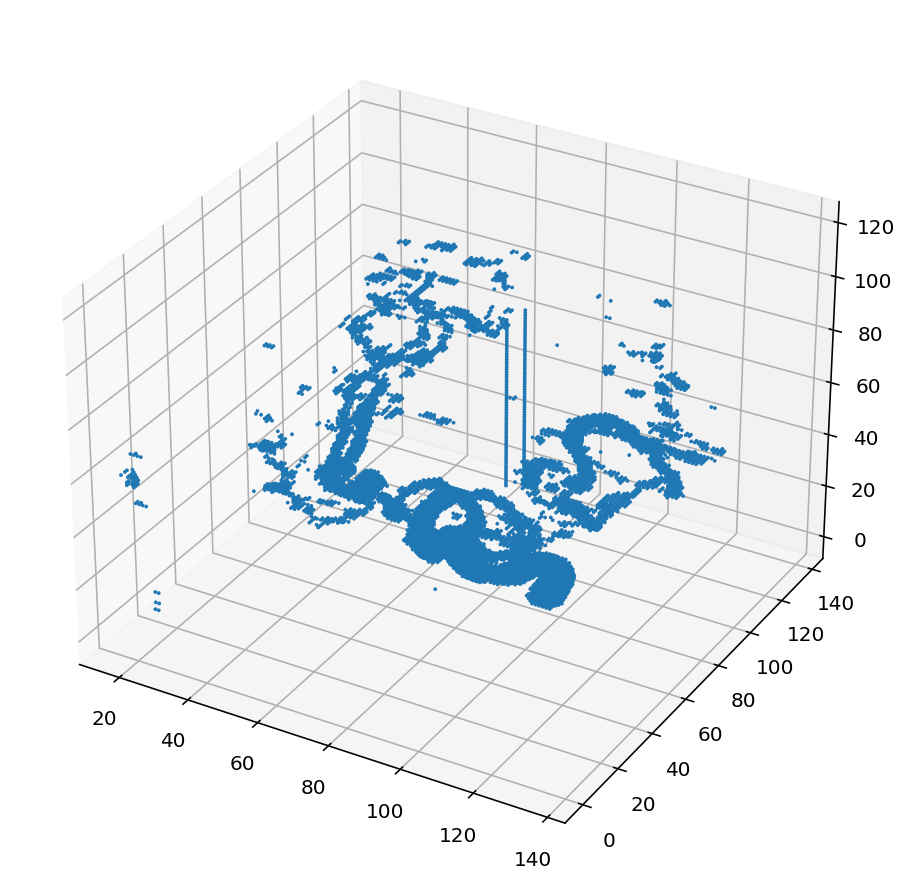

In [47]:
evaluation.draw_mask_3d(uni[5],markersize = 0.8)

In [ ]:
evaluation.draw_mask_3d(labels_test[3],markersize=0.8)

In [ ]:
evaluation.draw_mask_3d(uni_labels[3],markersize=0.8)

In [ ]:
evaluation.draw_mask_3d(labels_test[5],markersize=0.8)

In [ ]:
evaluation.draw_mask_3d(uni_labels[5],markersize=0.8)

In [ ]:
evaluation.draw_mask_3d(labels_test[8],markersize=0.8)

In [ ]:
evaluation.draw_mask_3d(uni_labels[8],markersize=0.8)

In [ ]:
evaluation.draw_mask_3d(labels_test[1],markersize=0.8)

In [ ]:
evaluation.draw_mask_3d(uni_labels[1],markersize=0.8)

In [ ]:
evaluation.draw_mask_3d(labels_test[2],markersize=0.8)

In [ ]:
evaluation.draw_mask_3d(uni_labels[2],markersize=0.8)